# Change point detection on real statsbomb data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import json

import changepoint

## Statsbomb loading

In [3]:
# data path
db_path = '../statsbomb/statsbomb_euro2020.db'

# connect and query
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT COUNT(*) FROM matches;", conn)

# display sample data
df.head()

,COUNT(*)
0,51


In [4]:
# tables in the dataset
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,lineups
1,sqlite_sequence
2,frames_360
3,matches
4,events


In [5]:
# load the data from each table
lineups = pd.read_sql_query("SELECT * FROM lineups;", conn)
sqlite_sequence = pd.read_sql_query("SELECT * FROM sqlite_sequence;", conn)
frames_360 = pd.read_sql_query("SELECT * FROM frames_360;", conn)
matches = pd.read_sql_query("SELECT * FROM matches;", conn)
events = pd.read_sql_query("SELECT * FROM events;", conn)

In [6]:
# matches.sort_values('total_score', ascending=False)

In [7]:
matches['total_score'] = matches['home_score'] + matches['away_score']

highest_match = matches.sort_values('total_score', ascending=False).head(1)

match_id = highest_match.match_id.item()
highest_match

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,total_score
19,3794686,2021-06-28,18:00:00.000,Europe - UEFA Euro,2020,Croatia,Spain,3,5,available,...,4,Round of 16,Parken,Cüneyt Çakιr,Zlatko Dalić,Luis Enrique Martínez García,1.1.0,2,2,8


In [8]:
# Croatia vs Spain - 3794686
croatia_v_spain = events.loc[events.match_id==match_id, :]
croatia_v_spain

,fifty_fifty,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
134472,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,"{""formation"": 433.0, ""lineup"": [{""jersey_numbe...",Croatia,785,00:00:00.000,Starting XI,None
134473,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,"{""formation"": 433.0, ""lineup"": [{""jersey_numbe...",Spain,772,00:00:00.000,Starting XI,None
134474,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Croatia,785,00:00:00.000,Half Start,None
134475,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Spain,772,00:00:00.000,Half Start,None
134476,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Spain,772,00:00:00.000,Half Start,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139327,None,None,None,None,None,None,None,None,None,None,...,Tactical,103.0,Luka Ivanušec,28368.0,None,Croatia,785,00:08:02.399,Substitution,None
139328,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,"{""formation"": 433.0, ""lineup"": [{""jersey_numbe...",Spain,772,00:27:11.141,Tactical Shift,None
139329,None,Yellow Card,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Croatia,785,00:27:15.962,Bad Behaviour,None
139330,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Spain,772,00:30:49.995,Player Off,None


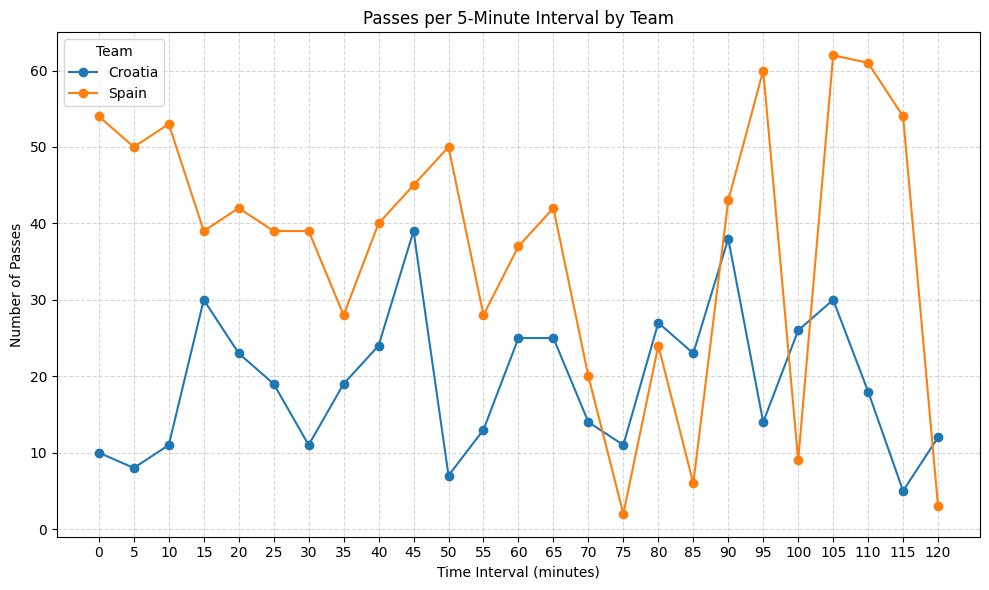

In [9]:
# passes by 5 minute intervals
query = f"""
WITH pass_intervals AS (
    SELECT
        team,
        ((minute / 5) * 5) AS interval_start,
        COUNT(*) AS pass_count
    FROM passes
    WHERE match_id = {match_id}
    GROUP BY team, interval_start
)
SELECT * FROM pass_intervals
ORDER BY interval_start, team;
"""

df = pd.read_sql_query(query, conn)

pivot_df = df.pivot(index="interval_start", columns="team", values="pass_count").fillna(0)

# Plot line graph
plt.figure(figsize=(10, 6))
for team in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[team], marker='o', label=team)

plt.title("Passes per 5-Minute Interval by Team")
plt.xlabel("Time Interval (minutes)")
plt.ylabel("Number of Passes")
plt.xticks(range(0, int(df["interval_start"].max() + 5), 5))
plt.legend(title="Team")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Change Point Detection

In [10]:
# code stolen from 
# https://github.com/promised-ai/changepoint/blob/master/pychangepoint/ChangePointExample.ipynb
# The repository for changepoint

def change_point_plot(data, change_point_history):
    """Plot the data and change point history with Maximum APosterori change-points"""
    n = len(data)
    
    fig, [data_ax, change_point_ax] = plt.subplots(
        2, 1, sharex=True, constrained_layout=True
    )

    data_ax.plot(data)

    data_ax.set_ylabel("data")
    change_point_ax.set_ylabel("$r_t$ (Run Length)")
    data_ax.set_xlim(0, len(data))

    np.sum(change_point_history, axis=1)

    cp_y_upper = np.max(np.argmax(change_point_history, axis=1))

    matshow = change_point_ax.matshow(
        change_point_history.T, origin="lower", aspect="auto"
    )
    change_point_ax.set_ylim(0, cp_y_upper)
    plt.colorbar(matshow, location="bottom", label=r"$P(r_t | \{x_i\}_{i=0}^t)$")

    data_lower, data_upper = 0.975 * np.min(data), 1.05 * np.max(data)

    regime_bot, regime_top = (
        data_lower - 0.1 * (data_upper - data_lower),
        data_lower,
    )
    data_ax.set_ylim(regime_bot, data_upper)

    map_change_points = np.hstack([changepoint.map_changepoints(change_point_history), n])

    for i, (a, b) in enumerate(zip(map_change_points[:-1], map_change_points[1:])):
        data_ax.fill_between(
            [a, b],
            [regime_bot, regime_bot],
            [regime_top, regime_top],
            color="#333333",
            alpha=0.5 if i % 2 == 0 else 1,
            linewidth=0,
        )

    return fig, (data_ax, change_point_ax), map_change_points

In [11]:
# how many passes in the entire game?
n_passes = len(croatia_v_spain.loc[(croatia_v_spain['type'] == 'Pass') & (croatia_v_spain['team']=='Croatia')])
print(f"There were {n_passes} passes by Croatia in the game, which makes an average of {n_passes / 90:.04f} passes per minute.")

There were 482 passes by Croatia in the game, which makes an average of 5.3556 passes per minute.


In [12]:
def find_change_points(dat, **kwargs):
    n = len(dat)

    argp = changepoint.ArgpCpd(
        **kwargs
    )

    changepoint_history = np.zeros((n+1, n+1))
    for i, x in enumerate(dat):
        cps = argp.step(x)
        changepoint_history[i, :len(cps)] = cps

    fig, (data_ax, change_point_ax), change_points = change_point_plot(dat, changepoint_history)

    change_points = change_points[1:-1]

    return fig, (data_ax, change_point_ax), change_points

5.22962962962963
Change points detected at indices: [12]


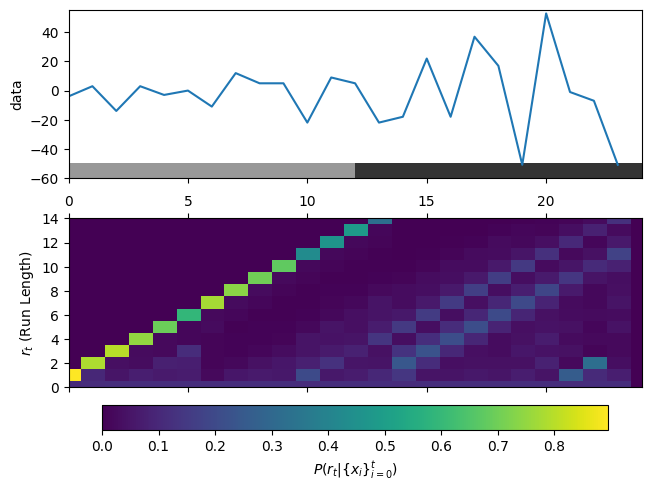

In [13]:
# change point detection
passes_croatia = pivot_df['Croatia'].to_numpy()
passes_spain = pivot_df['Spain'].to_numpy()

changepoint_data = passes_spain

print((sum(passes_spain) / 90 + sum(passes_croatia) / 90) / 3)
# argp = changepoint.ArgpCpd(
#     length_scale = 5.3556,
#     alpha0 = 0.2,
#     beta0 = 0.5,
#     logistic_hazard_b = 0.2,
#     )

# get slopes
n = len(changepoint_data)
slopes = np.zeros(n-1)
for i in range(1,n):
    slopes[i-1] = changepoint_data[i] - changepoint_data[i-1]

# changepoint_history = np.zeros((n+1, n+1))
# for i, x in enumerate(slopes):
#     cps = argp.step(x)
#     changepoint_history[i, :len(cps)] = cps

# fig, (data_ax, change_point_ax), change_points = change_point_plot(slopes, changepoint_history)

# change_points = change_points[1:-1]

fig, (data_ax, change_point_ax), change_points = find_change_points(slopes,
                                                                    scale=20,
                                                                    length_scale=5,
                                                                    alpha0 = 0.2,
                                                                    beta0 = 0.5,
                                                                    logistic_hazard_h = -2,
                                                                    logistic_hazard_b = 1)

print(f"Change points detected at indices: {change_points}")
plt.show()

In [14]:
change_time = pivot_df['Croatia']# .iloc[change_points[0], :]
change_time

interval_start
0      10
5       8
10     11
15     30
20     23
25     19
30     11
35     19
40     24
45     39
50      7
55     13
60     25
65     25
70     14
75     11
80     27
85     23
90     38
95     14
100    26
105    30
110    18
115     5
120    12
Name: Croatia, dtype: int64

In [15]:
np.unique(croatia_v_spain['type'])

array(['Bad Behaviour', 'Ball Receipt*', 'Ball Recovery', 'Block',
       'Carry', 'Clearance', 'Dispossessed', 'Dribble', 'Dribbled Past',
       'Duel', 'Foul Committed', 'Foul Won', 'Goal Keeper', 'Half End',
       'Half Start', 'Injury Stoppage', 'Interception', 'Miscontrol',
       'Own Goal Against', 'Own Goal For', 'Pass', 'Player Off',
       'Player On', 'Pressure', 'Referee Ball-Drop', 'Shot',
       'Starting XI', 'Substitution', 'Tactical Shift'], dtype=object)

## Event Correlation

In [16]:
'''
thoughts:
- inverse frequency weighting for the types
- inverse time difference weighting from change point
- multiply to get a score and check the highest score
'''
# inverse frequency weighting based on all event data
tf_idf = {}
n_events = len(events)
for event_type in np.unique(events['type']):
    tf_idf[event_type] = -np.log(len(events.loc[events['type']==event_type,:]) / n_events)

importance_order = sorted(list(tf_idf.keys()), key=lambda x : -tf_idf[x])
for event_type in importance_order:
    print(f"{event_type.ljust(len("Referee Ball-Drop"))}  :\t{tf_idf[event_type]:.04f}")

Offside            :	9.9716
Own Goal Against   :	9.7710
Own Goal For       :	9.7710
Player On          :	9.1243
Player Off         :	9.0778
Error              :	8.9908
Bad Behaviour      :	8.9108
50/50              :	8.1435
Shield             :	8.1084
Starting XI        :	7.5439
Referee Ball-Drop  :	7.3731
Tactical Shift     :	7.3405
Half End           :	6.6717
Half Start         :	6.6717
Injury Stoppage    :	6.5059
Substitution       :	6.0508
Dribbled Past      :	5.3731
Dispossessed       :	5.1777
Miscontrol         :	5.0197
Shot               :	5.0072
Foul Won           :	4.9707
Foul Committed     :	4.9289
Interception       :	4.8827
Dribble            :	4.8718
Goal Keeper        :	4.8463
Block              :	4.6901
Clearance          :	4.4356
Duel               :	4.0506
Ball Recovery      :	3.7693
Pressure           :	2.4911
Carry              :	1.4814
Ball Receipt*      :	1.2961
Pass               :	1.2571


In [21]:
from datetime import datetime
# calculate time difference score
relevant = croatia_v_spain.loc[:, ["minute", "second", "type", "possession_team", "team", "player", "position"]]

time_format = format="%H:%M:%S.%f"

relevant['time_delta'] = np.abs((12)*5 - relevant['minute'] + relevant['second']/60)
relevant['relevance'] = relevant['time_delta'].apply(lambda x : np.exp(-x)) * relevant['type'].apply(lambda x : tf_idf[x])
relevant = relevant.sort_values("relevance", ascending=False)

relevant[["type", "minute", "possession_team", "team", "player", "relevance"]].head(5)

,type,minute,possession_team,team,player,relevance
139004,Dispossessed,61,Croatia,Croatia,Joško Gvardiol,4.843748
138792,Duel,61,Croatia,Spain,César Azpilicueta Tanco,3.789403
138948,Ball Recovery,61,Croatia,Croatia,Luka Modrić,3.645740
138553,Pressure,61,Croatia,Spain,César Azpilicueta Tanco,2.254070
139127,Clearance,61,Croatia,Spain,César Azpilicueta Tanco,2.239674


# xG Changepoint

In [20]:
# same game
shots_xg = croatia_v_spain.loc[croatia_v_spain['type']=="Shot",[
    "minute",
    "shot_outcome",
    "shot_statsbomb_xg",
    "team",
]]

shots_xg['interval_start'] = shots_xg['minute'] // 5 * 5
shots_xg['goal'] = 0
shots_xg.loc[shots_xg['shot_outcome']=="Goal", 'goal'] = 1

shots_xg['performance'] = shots_xg['goal'] - shots_xg['shot_statsbomb_xg']

spain_shots = shots_xg.loc[shots_xg['team']=="Spain", :]
croatia_shots = shots_xg.loc[shots_xg['team']=='Croatia', :]

shots_xg

,minute,shot_outcome,shot_statsbomb_xg,team,interval_start,goal,performance
139227,8,Saved,0.051199,Spain,5,0,-0.051199
139228,12,Off T,0.011068,Spain,10,0,-0.011068
139229,15,Saved,0.189665,Spain,15,0,-0.189665
139230,18,Blocked,0.139367,Spain,15,0,-0.139367
139231,24,Off T,0.066410,Croatia,20,0,-0.066410
139232,25,Off T,0.034644,Croatia,25,0,-0.034644
139233,26,Off T,0.045750,Spain,25,0,-0.045750
139234,36,Wayward,0.022139,Spain,35,0,-0.022139
139235,37,Blocked,0.081281,Spain,35,0,-0.081281
139236,37,Saved,0.038581,Spain,35,0,-0.038581


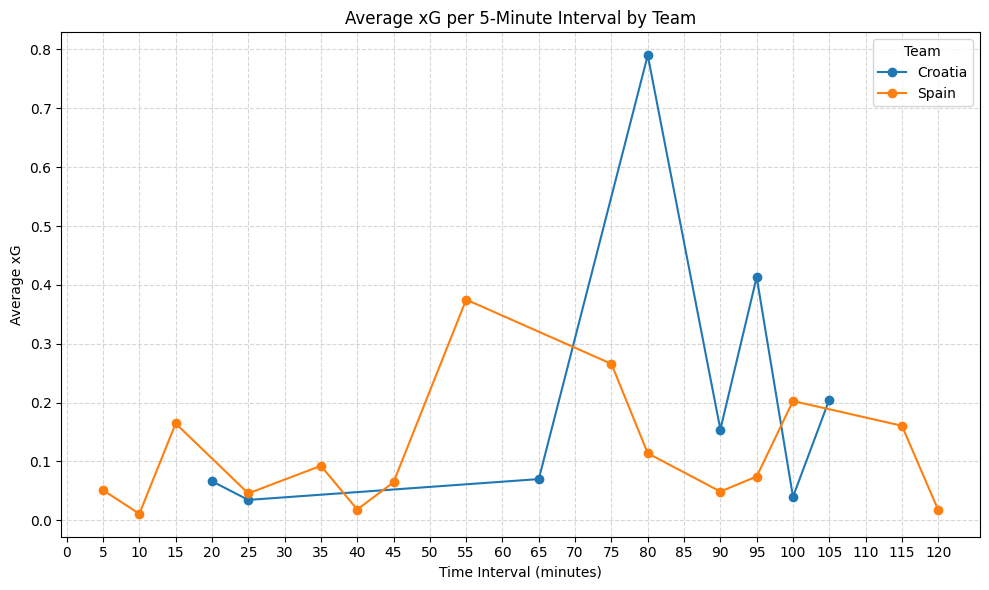

In [21]:
# # xG by 5 minute intervals

plt.figure(figsize=(10, 6))
for team in np.unique(shots_xg['team']):
    # get the average over 5 minute intervals 
    relevant = shots_xg.loc[shots_xg['team']==team, ["interval_start", "shot_statsbomb_xg", "performance"]]
    mean_xg = relevant.groupby(["interval_start"]).mean()
    # print(mean_xg)
    plt.plot(mean_xg.index, mean_xg['shot_statsbomb_xg'], marker='o', label=team)

plt.title("Average xG per 5-Minute Interval by Team")
plt.xlabel("Time Interval (minutes)")
plt.ylabel("Average xG")
plt.xticks(range(0, int(df["interval_start"].max() + 5), 5))
plt.legend(title="Team")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

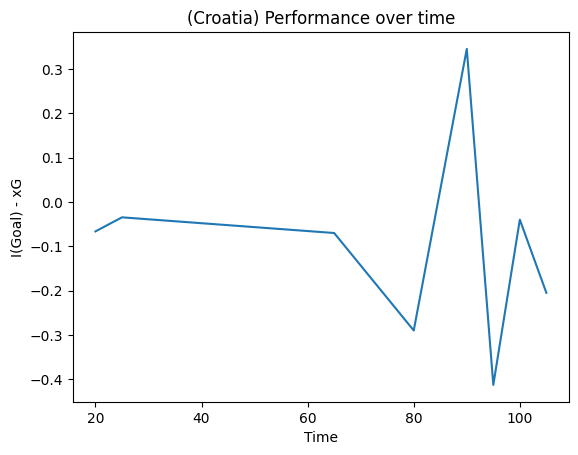

In [22]:
# spain or croatia
team = "Croatia"

relevant = shots_xg.loc[shots_xg['team']==team, ["interval_start", "shot_statsbomb_xg", "performance"]]
mean_xg = relevant.groupby(["interval_start"]).mean()

plt.plot(mean_xg.index, mean_xg['performance'])

plt.title(f"({team}) Performance over time")
plt.xlabel("Time")
plt.ylabel("I(Goal) - xG")

plt.show()

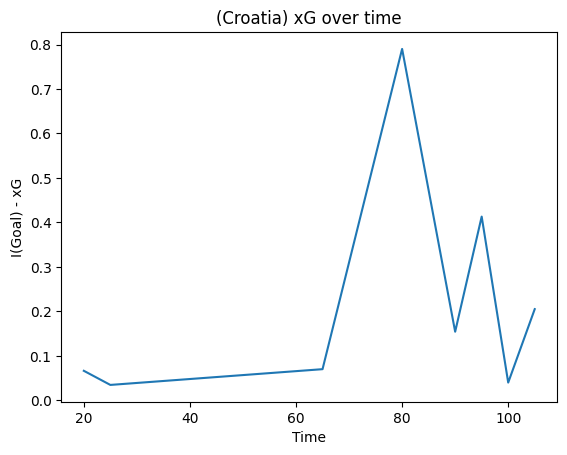

In [23]:
plt.plot(mean_xg.index, mean_xg['shot_statsbomb_xg'])

plt.title(f"({team}) xG over time")
plt.xlabel("Time")
plt.ylabel("I(Goal) - xG")

plt.show()

Change points detected at indices: [2]


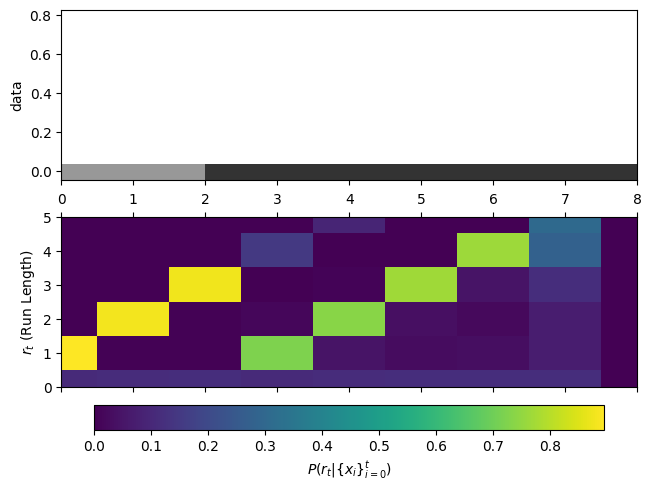

In [25]:
fig, (data_ax, change_point_ax), change_points = find_change_points(mean_xg['shot_statsbomb_xg'],
                                                                    scale=1,
                                                                    length_scale=1,
                                                                    noise_level=.01,
                                                                    alpha0 = 0.2,
                                                                    beta0 = 0.5,
                                                                    logistic_hazard_h = -2,
                                                                    logistic_hazard_b = 1)

print(f"Change points detected at indices: {change_points}")
plt.show()

# AUC of StatsBomb xG

In [43]:
from sklearn.metrics import roc_curve, auc

all_shots = events.loc[events['type']=="Shot", ["shot_statsbomb_xg", "shot_outcome"]]
all_shots['goal'] = 0
all_shots.loc[all_shots['shot_outcome']=="Goal", 'goal'] = 1

all_shots

,shot_statsbomb_xg,shot_outcome,goal
3603,0.052236,Off T,0
3604,0.009444,Blocked,0
3605,0.098552,Off T,0
3606,0.006578,Off T,0
3607,0.051247,Blocked,0
...,...,...,...
192282,0.783500,Post,0
192283,0.783500,Goal,1
192284,0.783500,Saved,0
192285,0.783500,Saved to Post,0


In [44]:
fpr, tpr, thres = roc_curve(all_shots['goal'], all_shots['shot_statsbomb_xg'])
auroc = auc(fpr, tpr)

auroc

np.float64(0.8384536610343062)